##### 【 ML - 생선 분류 모델 만들기 】

- 주__제 : 2개 종류 생선 분류 모델 만들기
- 학습종류: 지도학습 -> 분류
- 학습방법: 다양한 분류 알고리즘들 => KNN 최근접이웃알고리즘

- 데이터셋
    * 학습용 데이터셋
        - 모델 학습에 즉, 데이터의 규칙과 패턴 찾기위해서 사용되는 데이터셋

    * 검증용 데이터셋
        - 모델 학습 중 제대로 규칙과 패턴 찾고 있는지 검사하기 위한 데이터셋
        - scikit-learn은 fit()메서드로 학습 종료되어서 사용 할 수 없음
        - 교차검증, 일부 학습 알고리즘에서는 사용 가능

    * 테스트용 데이터셋
        - 학습 완료 후 성능검사에 사용되는 데이터셋
        - 추가 학습 진행 여부 결정 기준이 됨!
        - ★절대 학습에 사용되면 안됨!!★

[1] 데이터 확인 : 피쳐와 타겟 <hr>

In [2]:
## [1-1] 모듈 로딩 및 데이터 준비
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib

## ML 학습알고리즘 모델
from sklearn.neighbors import KNeighborsClassifier
## 데이터셋 관련
from sklearn.model_selection import train_test_split

In [9]:
## CoW 기능 활성화 : 데이터 변경시 복사 후 처리
pd.options.mode.copy_on_write = True

In [10]:
## [1-2] 데이터 로딩 및 빙어와도미 데이터만 추출
DATA_FILE='../Data/bream_smelt_best.csv'

## 품종, 무게, 길이 컬럼만 추출
allDF = pd.read_csv(DATA_FILE, usecols=[0,1,2])
#display(allDF.head(3))

## Bream 도미, Smelt 빙어 행만 추출
fishDF = allDF[(allDF.Species == 'Bream') | (allDF.Species == 'Smelt')]

## 행인덱스 초기화
fishDF.reset_index(drop=True, inplace=True)
#display(fishDF.head(3), fishDF.tail(3))
#fishDF.info()

In [38]:
## [1-3] 무게와 길이 피쳐와 품종 분류 가능 여부
# pd.set_option('future.no_silent_downcasting', True)
# fishDF.loc[:, 'Species'] = fishDF.loc[:, 'Species'].replace({'Bream':0, 'Smelt':1})
# fishDF.Species = fishDF.Species.astype('category')
# fishDF.Species


In [11]:
## 품종 컬럼 타입 변환 저장
speciesSR = fishDF.Species
fishDF.Species=speciesSR.astype('category')
## 전체 데이터 타입 확인
fishDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   Species  1000 non-null   category
 1   Weight   1000 non-null   float64 
 2   Length   1000 non-null   float64 
dtypes: category(1), float64(2)
memory usage: 16.9 KB


In [12]:
## 카테고리 접근자 cat 사용
print(f'[categories] => {fishDF.Species.cat.categories}')
print(f'[codes]      =>\n{fishDF.Species.cat.codes}')

[categories] => Index(['Bream', 'Smelt'], dtype='object')
[codes]      =>
0      0
1      0
2      0
3      0
4      0
      ..
995    1
996    1
997    1
998    1
999    1
Length: 1000, dtype: int8


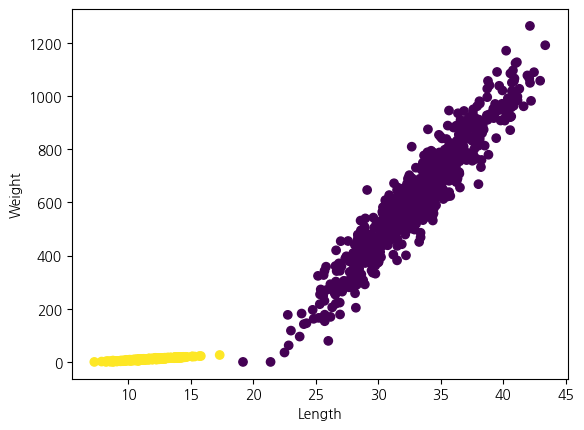

,Weight,Length
Weight,1.000000,0.961572
Length,0.961572,1.000000


In [13]:
## - 시각화 : 산점도 => 색상을 품종에따라 다르게 설정 c 매개변수
plt.scatter(fishDF.Length, fishDF.Weight, c=fishDF.Species.cat.codes )
plt.xlabel('Length')
plt.ylabel('Weight')
plt.show()

## - 상관계수
fishDF.corr(numeric_only=True)


[2] 피쳐/데이터와 타겟/라벨 분리<hr>

In [14]:
## 학습용 피쳐/데이터와 타겟/라벨 분리
## -> 피쳐/데이터 : 2D
featureDF = fishDF[fishDF.columns[1:]]

## -> 타겟/라벨 : 1D
targetSR  = fishDF[fishDF.columns[0]]

print(f'featureDF : {featureDF.shape} / {featureDF.ndim}D')
print(f'targetSR  : {targetSR.shape} / {targetSR.ndim}D')



featureDF : (1000, 2) / 2D
targetSR  : (1000,) / 1D


[3] 학습용, 테스트용 데이터셋 분리 <hr>
- 일반적 : 학습용 : 테스트용 = 8 : 2
- 수집된 데이터에 따라서 학습용 데이터셋 비율 설정
- scikit-learn 기본값 => 7.5 : 2.5

In [16]:
## train_test_split(2D피쳐, 1D타겟, ....) => 반환 4개 원소 튜플
## 매개변수
## -> test_size  = 0.25
## -> train_size = 0.75
## -> random_staate = None    : 전달한 데이터셋 섞어서 랜덤 추출
## -> stratify      = None    : 분류 학습 시 꼭 필수 설정, 데이터의 라벨/타겟 동일 비율 설정
x_train, x_test, y_train, y_test = train_test_split(featureDF,
                                                    targetSR,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=targetSR)

## 학습용, 테스트용 데이터 개수
print(f'[학습용] {x_train.shape} {x_train.ndim}D, {y_train.shape} {y_train.ndim}D')
print(f'[테스트용] {x_test.shape} {x_test.ndim}D, {y_test.shape} {y_test.ndim}D')

## 2개 라벨/클래스 Bream, Smelt 비율
targetL = (targetSR.value_counts()/targetSR.shape[0]).to_list()
trainL = (y_train.value_counts()/y_train.shape[0]).to_list()
testL = (y_test.value_counts()/y_test.shape[0]).to_list()

print(f'[Target] Bream : Smelt = {targetL[0]:.3f} : {targetL[1]:.3f}')
print(f'[Train]  Bream : Smelt = {trainL[0]:.3f} : {trainL[1]:.3f}')
print(f'[Test]   Bream : Smelt = {testL[0]:.3f} : {testL[1]:.3f}')

[학습용] (800, 2) 2D, (800,) 1D
[테스트용] (200, 2) 2D, (200,) 1D
[Target] Bream : Smelt = 0.700 : 0.300
[Train]  Bream : Smelt = 0.700 : 0.300
[Test]   Bream : Smelt = 0.700 : 0.300


[4] 학습 진행 ==> 학습용 데이터셋<hr>
- 학습 알고리즘의 기본 설정값 그대로 학습 진행 => 성능 점수 : 베이스 점수 / 최저 점수 / 기준 점수
- 성능 향상 위한 하이퍼파라미터 튜닝 진행 => 학습 알고리즘별 하이퍼파라미터 체크

In [19]:
## 훈련용/테스트용 성능 저장
scoreDict = {'Train':[], 'Test':[]}

## 최근접 이웃수 n_neighbors 범위 : 1 ≤ ~ ≤ √데이터수
MAX_K = 31

## 최적 성능의 k 즉, n_neighbors 찾기
for k  in range(1, MAX_K):
    ##- 모델 인스턴스 생성
    kModel = KNeighborsClassifier(n_neighbors=k)

    ##- 모델 학습 : 학습용 데이터셋
    kModel.fit(x_train, y_train)

    ##- 모델 성능평가 : 테스트용 데이터셋
    train_score = kModel.score(x_train, y_train)
    test_score = kModel.score(x_test, y_test)
    print(f'[n_neighbors-{k}]  train_score : {train_score:.6f}, test_score : {test_score:.6f}')

    ##- 학습과 테스트 성능비교 위한 저장
    scoreDict['Train'].append(train_score)
    scoreDict['Test'].append(test_score)

[n_neighbors-1]  train_score : 1.000000, test_score : 1.000000
[n_neighbors-2]  train_score : 1.000000, test_score : 1.000000
[n_neighbors-3]  train_score : 0.998750, test_score : 1.000000
[n_neighbors-4]  train_score : 0.998750, test_score : 1.000000
[n_neighbors-5]  train_score : 0.996250, test_score : 1.000000
[n_neighbors-6]  train_score : 0.996250, test_score : 1.000000
[n_neighbors-7]  train_score : 0.996250, test_score : 1.000000
[n_neighbors-8]  train_score : 0.996250, test_score : 1.000000
[n_neighbors-9]  train_score : 0.993750, test_score : 1.000000
[n_neighbors-10]  train_score : 0.993750, test_score : 1.000000
[n_neighbors-11]  train_score : 0.993750, test_score : 1.000000
[n_neighbors-12]  train_score : 0.993750, test_score : 1.000000
[n_neighbors-13]  train_score : 0.993750, test_score : 1.000000
[n_neighbors-14]  train_score : 0.993750, test_score : 1.000000
[n_neighbors-15]  train_score : 0.993750, test_score : 1.000000
[n_neighbors-16]  train_score : 0.993750, test_sc

[<Axes: > <Axes: >]


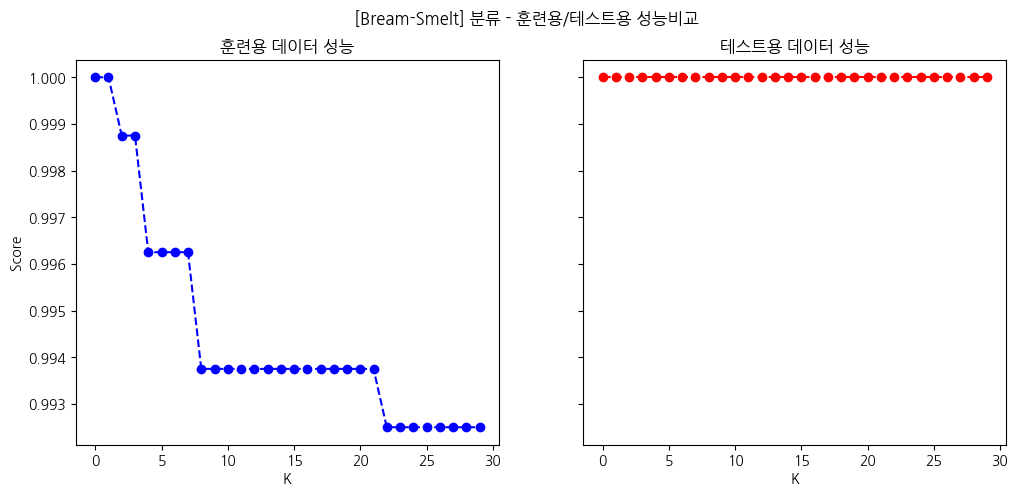

In [18]:
##- k 개수에 따른 학습 및 테스트 성능 시각화
fig, axes = plt.subplots(1,2, sharey=True, figsize=(12, 5))
print(axes)

axes[0].plot(scoreDict['Train'], 'bo--')
axes[0].set_xlabel('K')
axes[0].set_ylabel('Score')
axes[0].set_title("훈련용 데이터 성능")

axes[1].plot(scoreDict['Test'], 'ro--')
axes[1].set_xlabel('K')
axes[1].set_title("테스트용 데이터 성능")

plt.suptitle('[Bream-Smelt] 분류 - 훈련용/테스트용 성능비교')
plt.show()

In [ ]:
### ==============================================
### => 최적의 K = 3 : 홀수. 학습한 모델 인스턴스 생성
### ============================================== 
kModel = KNeighborsClassifier(n_neighbors=3)
kModel.fit(x_train, y_train)

,n_neighbors,3
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


[5] 성능평가 : 테스트용 데이터셋 <hr>
- 학습이 잘 되었는지 비교 평가
- 학습용 데이터셋 성능과 테스트용 데이터셋 성능 비교
- 평가
    * Good :  학습용 점수와  테스트용 점수 비슷 또는 테스트용 점수가 높음
    * bad  :  학습용 점수와  테스트용 점수 낮은 경우 / 테스트용 점수만 낮은 경우

In [21]:
## 학습용/테스트용 점수 계산
train_score = kModel.score(x_train, y_train)
test_score = kModel.score(x_test, y_test)

print(f'[Train] {train_score}, [Test] {test_score}')

[Train] 0.99875, [Test] 1.0
